In [ ]:
from quantile_regression.entropic_optimal_transport import EntropicOTQuantileRegression
from old_source_code.data import create_joint_x_y
import torch
from utils import TrainParams

X, Y = create_joint_x_y(1000)
X_batch = torch.from_numpy(X)
Y_batch = torch.from_numpy(Y)
dataloader = torch.utils.data.DataLoader(torch.utils.data.TensorDataset(X_batch, Y_batch), batch_size=128, shuffle=True)
train_params = TrainParams(num_epochs=500, learning_rate=1e-3, verbose=True)

eotqr = EntropicOTQuantileRegression(input_dimension=X.shape[1] + Y_batch.shape[1], hidden_dimension=10, number_of_hidden_layers=5, epsilon=1e-7)
_ = eotqr.fit(dataloader, train_params=train_params)

Epoch: 500, objective: 3.463: 100%|██████████| 500/500 [10:22<00:00,  1.24s/it]


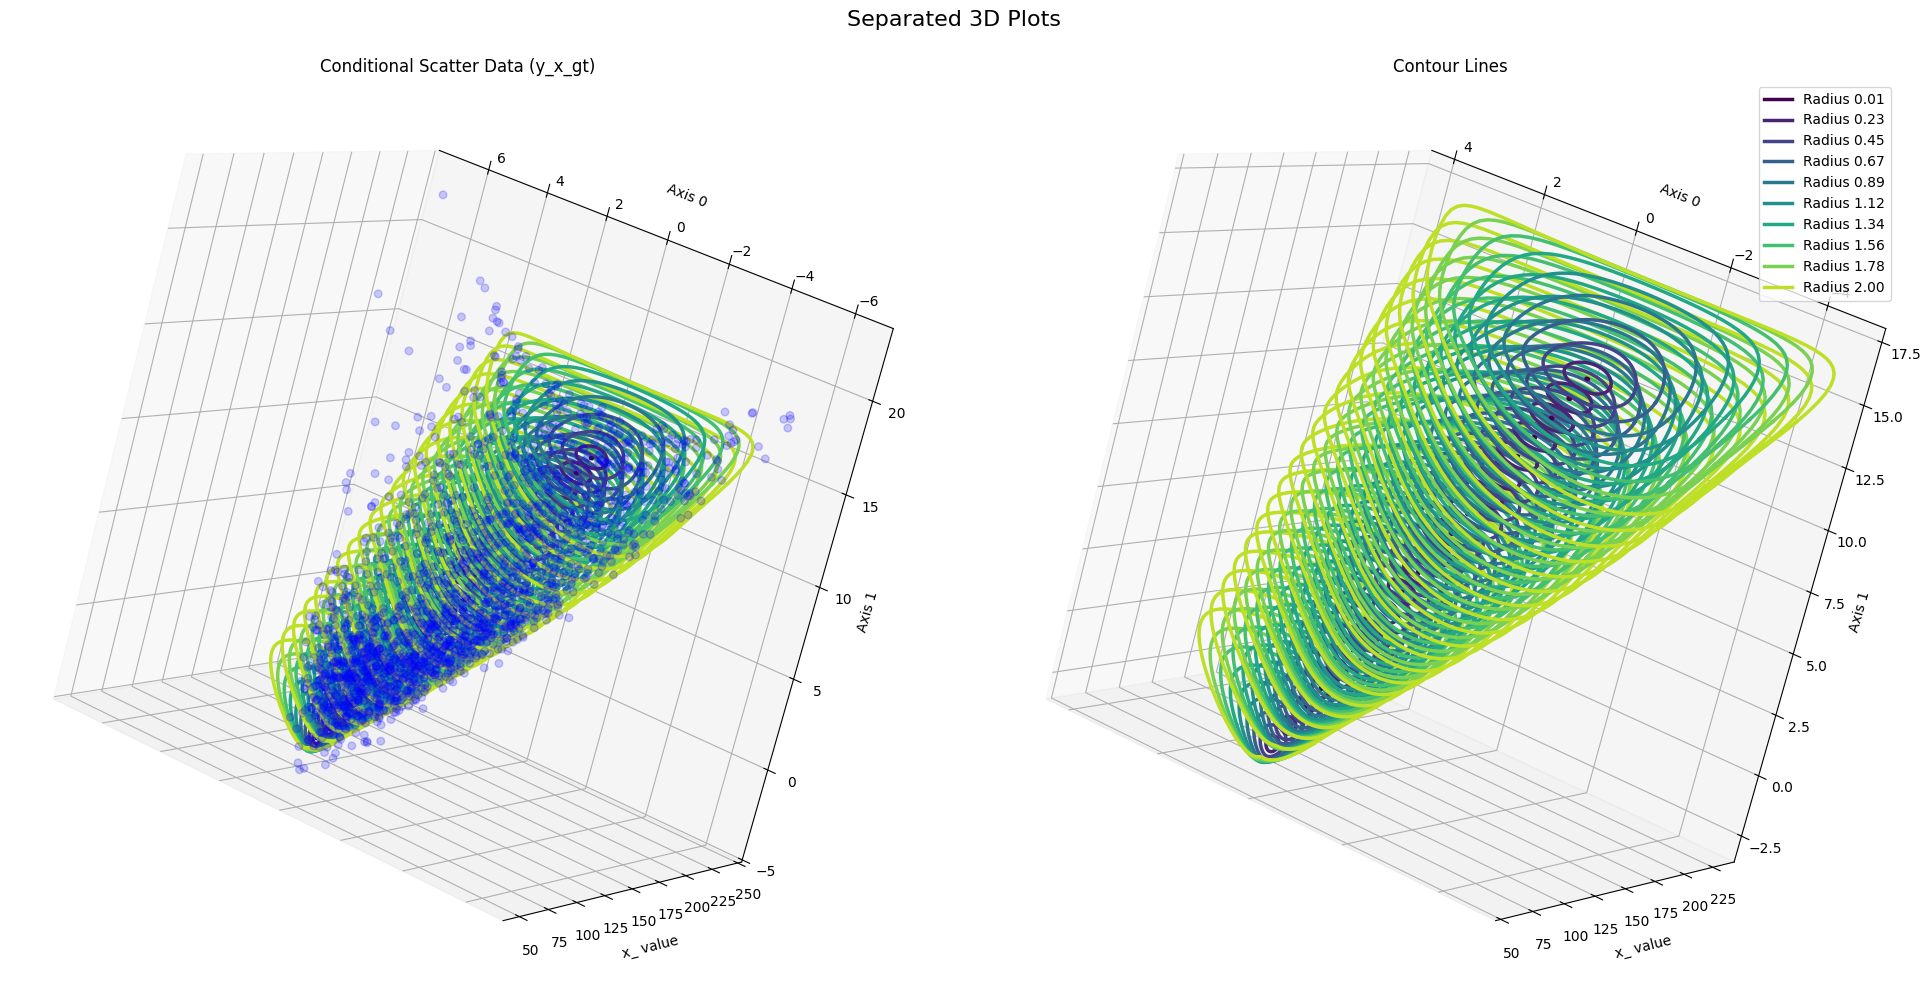

In [4]:
%matplotlib inline
import matplotlib.pyplot as plt
from old_source_code.data import create_conditional_x
import matplotlib
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(20, 10), subplot_kw={'projection': '3d'})
fig.suptitle('Separated 3D Plots', fontsize=16)

ax1.set_title('Conditional Scatter Data (y_x_gt)')
ax1.set_xlabel('Axis 0')
ax1.set_ylabel('Axis 1')
ax1.set_zlabel('x_ value')

for x_ in range(50, 250, 10):
    x = torch.tensor([x_ / 100, 1])

    # This section is now active for the first plot
    _, y_x_gt = create_conditional_x(n_points=100, x_value=x[0].item())
    z_scatter = torch.full((_.shape[0],),  x_)
    ax1.scatter(y_x_gt[:, 0], y_x_gt[:, 1], z_scatter, color='blue', marker='o', s=30, alpha=0.2)

ax1.view_init(elev=-55, azim=154, roll=-83)

ax2.set_title('Contour Lines')
ax2.set_xlabel('Axis 0')
ax2.set_ylabel('Axis 1')
ax2.set_zlabel('x_ value')
color_map = matplotlib.colormaps['viridis']

loop_start_value = 50
for x_ in range(loop_start_value, 250, 10):
    X_batch = torch.tensor([[x_ / 100]]).repeat(100, 1)

    radii = torch.linspace(0.01, 2, 10)
    colors = [color_map(i / len(radii)) for i in range(len(radii))]
    for contour_radius, color in zip(radii, colors):
        pi = torch.linspace(-torch.pi, torch.pi, 100) # Use linspace for a perfectly smooth circle

        u = torch.stack([
            contour_radius * torch.cos(pi),
            contour_radius * torch.sin(pi),
        ]).T

        pushforward_of_u = eotqr.push_forward_u_given_x(u, X=X_batch).detach().cpu()
        z_line = torch.full((pushforward_of_u.shape[0], ), x_)

        label = f'Radius {contour_radius:.2f}' if x_ == loop_start_value else ""
        ax2.plot(pushforward_of_u[:, 0], pushforward_of_u[:, 1], z_line, color=color, linewidth=2.5, label=label)
        ax1.plot(pushforward_of_u[:, 0], pushforward_of_u[:, 1], z_line, color=color, linewidth=2.5, label=label)

ax2.view_init(elev=-55, azim=154, roll=-83)
ax2.legend()

plt.tight_layout(rect=[0, 0, 1, 0.96])
plt.show()